In [65]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go
import chart_studio.plotly as py
import matplotlib.pyplot as plt

In [49]:
# get EURO-US exchange rate data from 2000-01-01 to 2022-1-1

df_eu = yf.download('EURUSD=X', start='2000-01-01', end='2022-1-1', progress=False)
df_eu = df_eu.reset_index()
df_eu = df_eu[['Date', 'Close']]
df_eu.columns = ['Date', 'EURUSD']

# change the frequency of the data to monthly
df_eu = df_eu.set_index('Date')
df_eu = df_eu.resample('M').mean()
df_eu = df_eu.reset_index()

# get rid of the days in the date column
df_eu['Date'] = df_eu['Date'].dt.strftime('%Y-%m')

df_eu.head()


,Date,EURUSD
0,2003-12,1.231372
1,2004-01,1.260813
2,2004-02,1.264357
3,2004-03,1.226723
4,2004-04,1.199692


In [50]:
# get China-US exchange rate data from 2000-01-01 to 2022-1-1
df = yf.download("CNY=X", start="2000-01-01", end="2022-1-1")
df = df.reset_index()
df = df.rename(columns={"Date": "date", "Close": "cny_usd"})
df.head()

# change the frequency of the data from daily to monthly
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()
# change to monthly frequency, only include the month not the day
df = df.resample('M').mean()
df = df.reset_index()
df.head()

# get rid of the day in the date column
df['date'] = df['date'].dt.strftime('%Y-%m')
#only keep close price
df_china = df[['date', 'cny_usd']]
# rename the cny_usd column to CNYUSD
df_china = df_china.rename(columns={'cny_usd': 'CNYUSD'})

df_china.head()


[*********************100%***********************]  1 of 1 completed


,date,CNYUSD
0,2001-06,8.276800
1,2001-07,8.276814
2,2001-08,8.276969
3,2001-09,8.276850
4,2001-10,8.276842


In [51]:
import pandas_datareader.data as web
import datetime

# Define the time period
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2022, 1, 1)

# Get the trade balance data for the US
df_trade = web.DataReader('BOPGSTB', 'fred', start_date, end_date)

# get rid of the day in the date column
df_trade['date'] = df_trade.index.strftime('%Y-%m')
df_trade = df_trade.reset_index(drop=True)

df_trade.head()

,BOPGSTB,date
0,-27131.0,2000-01
1,-29794.0,2000-02
2,-30557.0,2000-03
3,-28598.0,2000-04
4,-29165.0,2000-05


In [52]:
# merge the two dataframes
df_final = pd.merge(df_china, df_trade, how='left', left_on="date", right_on='date')
# merge the third dataframe
df_final = pd.merge(df_final, df_eu, how='right', left_on="date", right_on='Date')
# change eursd to 1/eurusd
df_final['EURUSD'] = 1/df_final['EURUSD']
df_final.tail()

,date,CNYUSD,BOPGSTB,Date,EURUSD
212,2021-08,6.475914,-71426.0,2021-08,0.849553
213,2021-09,6.456764,-78334.0,2021-09,0.849052
214,2021-10,6.420943,-68156.0,2021-10,0.862022
215,2021-11,6.390591,-77977.0,2021-11,0.875864
216,2021-12,6.368196,-78867.0,2021-12,0.884393


In [56]:
# import ols
from statsmodels.formula.api import ols

In [71]:
# analyze the data
df_final.describe()
# correlation between the trade balance and the exchange rate
corr = df_final["CNYUSD"].corr(df_final["BOPGSTB"])
model = ols("BOPGSTB ~ CNYUSD", data=df_final).fit()
# print the model result nicely
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                BOPGSTB   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     58.69
Date:                Tue, 14 Feb 2023   Prob (F-statistic):           6.23e-13
Time:                        15:21:27   Log-Likelihood:                -2295.2
No. Observations:                 217   AIC:                             4594.
Df Residuals:                     215   BIC:                             4601.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2681.8315   6748.689      0.397      0.6

In [60]:
# now for EURUSD
corr = df_final["EURUSD"].corr(df_final["BOPGSTB"])
model = ols("EURUSD ~ BOPGSTB", data=df_final).fit()
# print the model result nicely
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 EURUSD   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1711
Date:                Tue, 14 Feb 2023   Prob (F-statistic):              0.680
Time:                        15:03:29   Log-Likelihood:                 256.08
No. Observations:                 217   AIC:                            -508.2
Df Residuals:                     215   BIC:                            -501.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8124      0.024     34.350      0.0

Text(0, 0.5, 'CNYUSD')

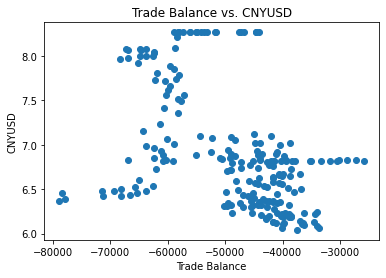

In [70]:
# visualize the data
# use a graph object
plt.scatter(df_final["BOPGSTB"], df_final["CNYUSD"])
plt.title("Trade Balance vs. CNYUSD")
plt.xlabel("Trade Balance")
plt.ylabel("CNYUSD")


In [74]:
# plot CNYUSD exchange rate and trade balance over time
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['date'], y=df_final['CNYUSD'], name='CNYUSD'))
fig.add_trace(go.Scatter(x=df_final['date'], y=df_final['BOPGSTB']/10000, name='Trade Balance'))
fig.update_layout(title='CNYUSD Exchange Rate and Trade Balance (in ten billions) Over Time',
                     xaxis_title='Date',
                        yaxis_title='CNYUSD')
fig.show()
